# astropy.io - 2
---

## 4. Edit a FITS header

This example describes how to edit a value in a FITS header using astropy.io.fits.

주) astropy.io.fits를 이용한 FITS 헤더 정보 수정 예제

In [1]:
from astropy.io import fits
from astropy.utils.data import get_pkg_data_filename

In [2]:
import os 
os.getcwd()

'E:\\astropy'

Download a FITS file:

In [3]:
fits_file = get_pkg_data_filename('tutorials/FITS-Header/input_file.fits')

Look at contents of the FITS file

In [4]:
fits.info(fits_file)

Filename: C:\Users\jeffr\.astropy\cache\download\url\519010d87325a22575dc1d16f3a05d26\contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (100, 100)   float64   
  1                1 ImageHDU         8   (128, 128)   float64   


Look at the headers of the two extensions:

In [5]:
print("Before modifications:")
print()
print("Extension 0:")
print(repr(fits.getheader(fits_file, 0)))
print()
print("Extension 1:")
print(repr(fits.getheader(fits_file, 1)))

Before modifications:

Extension 0:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
EXTEND  =                    T                                                  
OBJECT  = 'CAT     '                                                            
ANEKEY  = 'some value'                                                          

Extension 1:
XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  128                             

astropy.io.fits provides an object-oriented interface for reading and interacting with FITS files, but for small operations (like this example) it is often easier to use the convenience functions.

To edit a single header value in the header for extension 0, use the setval() function. For example, set the OBJECT keyword to ‘M31’:

ex) 단일 헤더값 변경

In [6]:
# 기본 ext 값은 extension 0

fits.setval(fits_file, 'OBJECT', value = 'M31')

With no extra arguments, this will modify the header for extension 0, but this can be changed using the ext keyword argument. For example, we can specify extension 1 instead:

In [7]:
# ext 인자를 이용하여 extension 1의 값을 변경

fits.setval(fits_file, 'OBJECT', value = 'M31', ext = 1)

ex2) 새로운 키워드-밸류 쌍(pair) 생성

This can also be used to create a new keyword-value pair (“card” in FITS lingo):

In [8]:
fits.setval(fits_file, 'ANEKEY', value = 'some value')

Again, this is useful for one-off modifications, but can be inefficient for operations like editing multiple headers in the same file because setval() loads the whole file each time it is called. To make several modifications, it’s better to load the file once:

**(참고)** setval 함수는 하나의 값을 변경할 때 유용하나, 다중 헤더를 수정할 때는 비효율적이다. 
-> 다중 헤더(여러개의 extension 내의 값)를 변경할 때는 fits.open을 이용하여 업데이트하는 것이 효율적임

In [9]:
# fits.open 함수를 이용하여 업데이트 실시 

with fits.open(fits_file, 'update') as f:
    for hdu in f:
        hdu.header['OBJECT'] = 'CAT'

In [10]:
print("After modifications")
print()
print("Extension 0:")
print(repr(fits.getheader(fits_file, 0)))
print()
print("Extension 1:")
print(repr(fits.getheader(fits_file, 1)))

After modifications

Extension 0:
SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
EXTEND  =                    T                                                  
OBJECT  = 'CAT     '                                                            
ANEKEY  = 'some value'                                                          

Extension 1:
XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  128                               

## 5. Create a very large FITS file from scratch

This example demonstrates how to create a large file (larger than will fit in memory) from scratch using astropy.io.fits.

주) 메모리보다 큰 FITS 파일을 생성하는 방법에 대한 예제

By: Erik Bray

License: BSD

Normally to create a single image FITS file one would do something like:

In [11]:
import os
import numpy as np
from astropy.io import fits

data = np.zeros((40000, 40000), dtype = np.float64)
hdu = fits.PrimaryHDU(data = data)

Then use the astropy.io.fits.writeto() method to write out the new file to disk

astropy.io.fits.writeto() 함수를 이용해 새로운 파일 생성하기

In [12]:
hdu.writeto('large.fits')

However, a 40000 x 40000 array of doubles is nearly twelve gigabytes! Most systems won’t be able to create that in memory just to write out to disk. In order to create such a large file efficiently requires a little extra work, and a few assumptions.

First, it is helpful to anticipate about how large (as in, how many keywords) the header will have in it. FITS headers must be written in 2880 byte blocks, large enough for 36 keywords per block (including the END keyword in the final block). Typical headers have somewhere between 1 and 4 blocks, though sometimes more.

Since the first thing we write to a FITS file is the header, we want to write enough header blocks so that there is plenty of padding in which to add new keywords without having to resize the whole file. Say you want the header to use 4 blocks by default. Then, excluding the END card which Astropy will add automatically, create the header and pad it out to 36 * 4 cards.

Create a stub array to initialize the HDU; its exact size is irrelevant, as long as it has the desired number of dimensions

In [13]:
data = np.zeros((100, 100), dtype = np.float64)
hdu = fits.PrimaryHDU(data = data)
header = hdu.header
while len(header) < (36*4 - 1):
    header.append() # Adds a blank card to the end

Now adjust the NAXISn keywords to the desired size of the array, and write only the header out to a file. Using the `hdu.writeto()` method will cause astropy to “helpfully” reset the NAXISn keywords to match the size of the dummy array. That is because it works hard to ensure that only valid FITS files are written. Instead, we can write just the header to a file using the astropy.io.fits.Header.tofile method:

In [14]:
header['NAXIS1'] = 40000
header['NAXIS2'] = 40000
header.tofile('large.fits', overwrite = True)

# 위에서 large.fits를 만들었으므로 overwrite = True 인자를 넣어줘야 에러가 발생하지 않음

Finally, grow out the end of the file to match the length of the data (plus the length of the header). This can be done very efficiently on most systems by seeking past the end of the file and writing a single byte, like so:

In [15]:
with open('large.fits', 'rb+') as fobj:
    """
    # Seek past the length of the header, plus the length of the
    # Data we want to write.
    # 8 is the number of bytes per value, i.e. abs(header['BITPIX'])/8
    # (this example is assuming a 64-bit float)
    # The -1 is to account for the final byte that we are about to
    # write:
    """
    fobj.seek(len(header.tostring()) + (40000*40000*8) -1)
    fobj.write(b'\0')

More generally, this can be written:

In [16]:
shape = tuple(header[f'NAXIS{ii}'] for ii in range(1, header['NAXIS'] + 1))
shape

(40000, 40000)

```python
# More generally, this can be written:

with open('large.fits', 'rb+') as fobj:
    fobj.seek(len(header.tostring()) + (np.product(shape)*np.abs(header['BITPIX']//8)) -1)
    fobj.write(b'\0')
```

On modern operating systems this will cause the file (past the header) to be filled with zeros out to the ~12GB needed to hold a 40000 x 40000 image. On filesystems that support sparse file creation (most Linux filesystems, but not the HFS+ filesystem used by most Macs) this is a very fast, efficient operation. On other systems your mileage may vary.

This isn’t the only way to build up a large file, but probably one of the safest. This method can also be used to create large multi-extension FITS files, with a little care.

Finally, we’ll remove the file we created:

In [17]:
os.remove('large.fits')

## 6. Convert a 3-color image(JPG) to separate FITS images

This example opens an RGB JPEG image and writes out each channel as a separate FITS (image) file.

This example uses pillow to read the image, matplotlib.pyplot to display the image, and astropy.io.fits to save FITS files.

By: Erik Bray, Adrian Price-Whelan

License: BSD

주) 분리된 FITS 파일의 각 채널별 이미지를 RGB JPEG 파일로 변환하는 방법에 대한 예제

사용 패키지
- pillow: 이미지 불러오기
- matplotlib.pyplot: 이미지 디스플레이
- astropy.io.fits: FITS 파일로 저장

In [1]:
import scipy as sp
import numpy as np

import urllib

import matplotlib as mpl
import matplotlib.pyplot as plt

from PIL import Image

from astropy.io import fits
from astropy.utils.data import download_file
from astropy.visualization import astropy_mpl_style

Set up matplotlib and use a nicer set of plot parameters

In [2]:
plt.style.use(astropy_mpl_style)

Load and display the original 3-color jpeg image:

In [3]:
# urllib.request.urlretrieve('http://www.eg.bucknell.edu/~mligare/Hs-2009-14-a-web.jpg','Hs-2009-14-a-web.jpg')
image = Image.open('Hs-2009-14-a-web.jpg')

Image size: 232 x 400
Image bands: ('R', 'G', 'B')


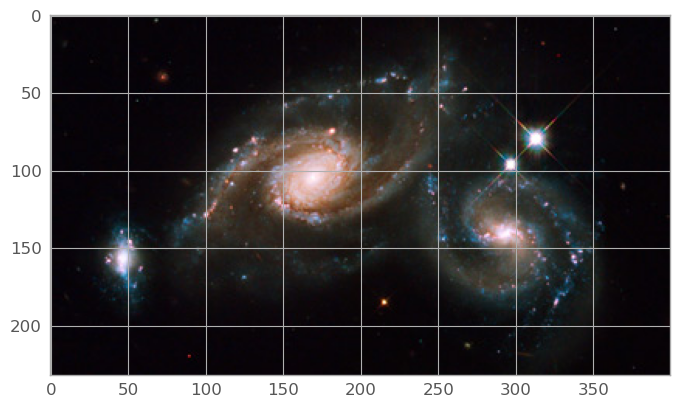

In [4]:
xsize, ysize = image.size
print(f"Image size: {ysize} x {xsize}")
print(f"Image bands: {image.getbands()}")
ax = plt.imshow(image)

Split the three channels (RGB) and get the data as Numpy arrays. The arrays are flattened, so they are 1-dimensional:

In [5]:
r, g, b = image.split()
r_data = np.array(r.getdata()) # data is now an array of length ysize*xsize
g_data = np.array(g.getdata())
b_data = np.array(b.getdata())
print(r_data.shape)

(92800,)


In [6]:
232*400

92800

Reshape the image arrays to be 2-dimensional:

In [7]:
r_data = r_data.reshape(ysize, xsize) # data is now a matrix (ysize, xsize)
g_data = g_data.reshape(ysize, xsize)
b_data = b_data.reshape(ysize, xsize)
print(r_data.shape)

(232, 400)


Write out the channels as separate FITS images. Add and visualize header info

In [8]:
red = fits.PrimaryHDU(data = r_data)
red.header['LATOBS'] = "32:11:56"
red.header['LONGOBS'] = "110:56"
red.writeto('red.fits')

green = fits.PrimaryHDU(data = g_data)
green.header['LATOBS'] = "32:11:56"
green.header['LONGOBS'] = "110:56"
green.writeto('green.fits')

blue = fits.PrimaryHDU(data = b_data)
blue.header['LATOBS'] = "32:11:56"
blue.header['LONGOBS'] = "110:56"
blue.writeto('blue.fits')

from pprint import pprint

pprint(red.header)

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                   32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  400                                                  
NAXIS2  =                  232                                                  
EXTEND  =                    T                                                  
LATOBS  = '32:11:56'                                                            
LONGOBS = '110:56  '                                                            


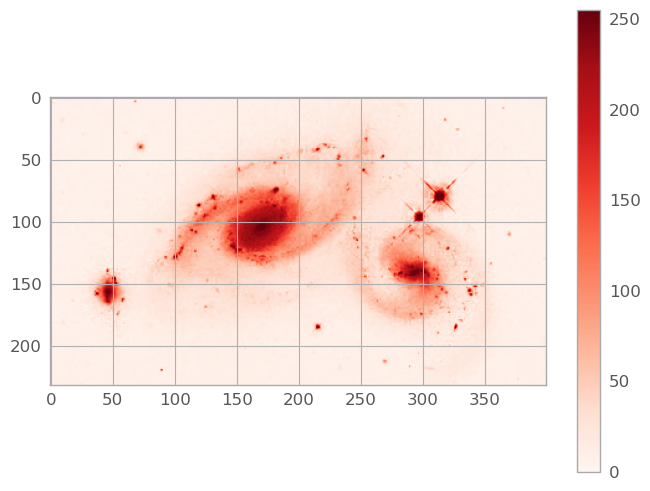

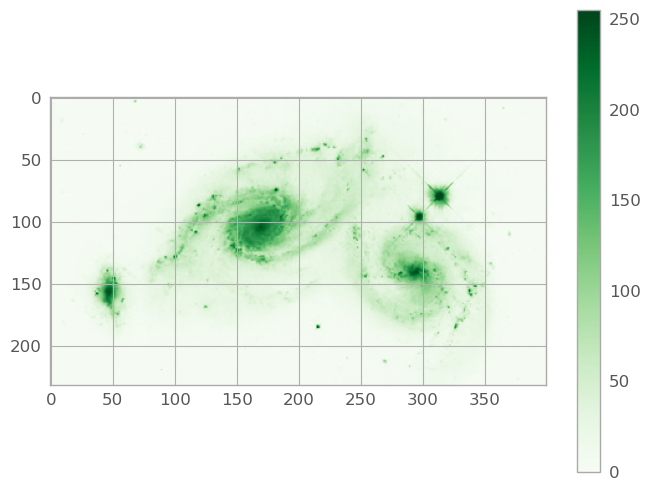

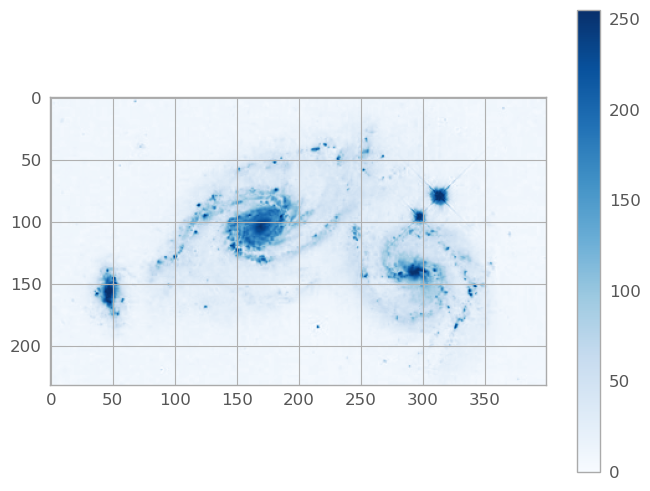

In [20]:
from astropy.io import fits
import matplotlib.pyplot as plt


#=========================================================#
# reds
#=========================================================#
# fits 파일 경로 지정
filename = 'red.fits'

# fits 파일 불러오기
hdul = fits.open(filename)

# 이미지 데이터 가져오기
data = hdul[0].data

# 이미지 plot
plt.imshow(data, cmap='Reds')
plt.colorbar()
plt.show()

# fits 파일 닫기
hdul.close()


#=========================================================#
# green
#=========================================================#
# fits 파일 경로 지정
filename = 'green.fits'

# fits 파일 불러오기
hdul = fits.open(filename)

# 이미지 데이터 가져오기
data = hdul[0].data

# 이미지 plot
plt.imshow(data, cmap='Greens')
plt.colorbar()
plt.show()

# fits 파일 닫기
hdul.close()


#=========================================================#
# Blue
#=========================================================#
# fits 파일 경로 지정
filename = 'blue.fits'

# fits 파일 불러오기
hdul = fits.open(filename)

# 이미지 데이터 가져오기
data = hdul[0].data

# 이미지 plot
plt.imshow(data, cmap='Blues')
plt.colorbar()
plt.show()

# fits 파일 닫기
hdul.close()

C:\Users\jeffr\AppData\Local\Temp\ipykernel_17060\3933709226.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  data = imageio.imread(filename)


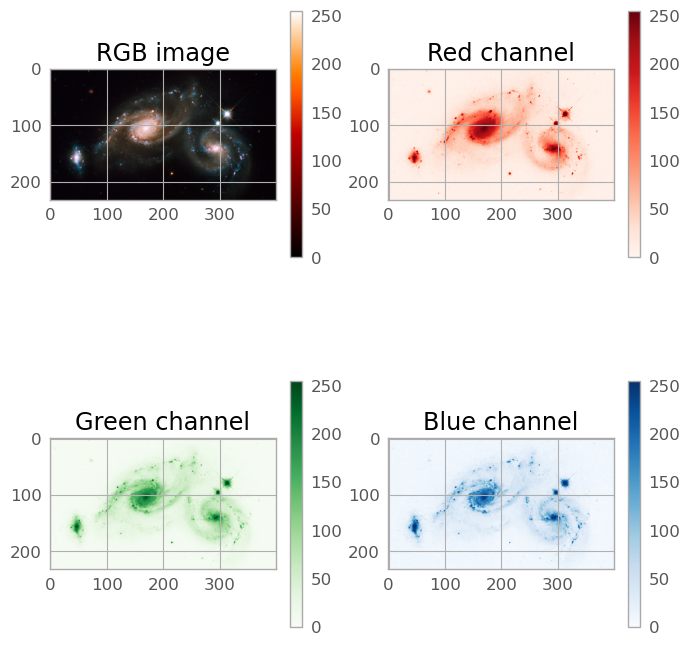

In [29]:
import imageio
import matplotlib.pyplot as plt

# jpg 파일 경로 지정
filename = 'Hs-2009-14-a-web.jpg'

# 이미지 파일 불러오기
data = imageio.imread(filename)

# # subplot 2x2 그리기
# fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# # RGB 이미지 plot
# axs[0, 0].imshow(data, vmin=0, vmax=255)
# axs[0, 0].set_title('RGB image')

# # red 이미지 plot
# axs[0, 1].imshow(data[:, :, 0], cmap='Reds', vmin=0, vmax=255)
# axs[0, 1].set_title('Red channel')

# # green 이미지 plot
# axs[1, 0].imshow(data[:, :, 1], cmap='Greens', vmin=0, vmax=255)
# axs[1, 0].set_title('Green channel')

# # blue 이미지 plot
# axs[1, 1].imshow(data[:, :, 2], cmap='Blues', vmin=0, vmax=255)
# axs[1, 1].set_title('Blue channel')

# subplot 2x2 그리기
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))

# RGB 이미지 plot
im1 = axs[0, 0].imshow(data, vmin=0, vmax=255)
axs[0, 0].set_title('RGB image')

# red 이미지 plot
im2 = axs[0, 1].imshow(data[:, :, 0], cmap='Reds', vmin=0, vmax=255)
axs[0, 1].set_title('Red channel')

# green 이미지 plot
im3 = axs[1, 0].imshow(data[:, :, 1], cmap='Greens', vmin=0, vmax=255)
axs[1, 0].set_title('Green channel')

# blue 이미지 plot
im4 = axs[1, 1].imshow(data[:, :, 2], cmap='Blues', vmin=0, vmax=255)
axs[1, 1].set_title('Blue channel')



# 컬러바 추가
fig.colorbar(im1, ax=axs[0, 0])
fig.colorbar(im2, ax=axs[0, 1])
fig.colorbar(im3, ax=axs[1, 0])
fig.colorbar(im4, ax=axs[1, 1])

# 그림 출력
plt.show()


Delete the files created

In [26]:
import os

os.remove('red.fits')
os.remove('green.fits')
os.remove('blue.fits')